In [1]:
import glob
import os
import numpy as np
from ip_basic.depth_map_utils import *
from ip_basic.vis_utils import *
from PIL import Image
import time

import matplotlib.pyplot as plt
import pickle as pkl

MAX_DEPTH = 10.00
DEPTH_PARAM1 = 351.30
DEPTH_PARAM2 = 1092.50
EMPTY = 0

N_ROWS = 480
N_COLS = 640

# Best settings so far: 
fill_type = 'fast'
extrapolate = True
blur_type = None

# Fast fill kernels
custom_kernel = DIAMOND_KERNEL_7
morph_kernel = FULL_KERNEL_5
dilation_kernel = FULL_KERNEL_7

def convert_to_metres(depth_image):
    return DEPTH_PARAM1 / (DEPTH_PARAM2 - depth_image)

def read_pgm(filename):

    """Return a raster of integers from a PGM as a list of lists."""
    raster = []
    try:
        with open(filename, 'rb') as pgmf:
            header = pgmf.readline()
            assert header[:2] == b'P5'
            (width, height) = [int(i) for i in header.split()[1:3]]
            depth = int(header.split()[3])
            assert depth <= 65535
            for y in range(height):
                row = []
                for y in range(width):
                    low_bits = ord(pgmf.read(1))
                    row.append(low_bits+255*ord(pgmf.read(1)))
                raster.append(row)
    except:
        print("Error reading file: {}".format(filename))
        return None
    return np.array(raster)

class SingleImageProcessSequence:
    def __init__(self, projected_depths, completed_depths, completed_depths_2, filled_depths):
        self.projected_depths = projected_depths
        self.completed_depths = completed_depths
        self.completed_depths_2 = completed_depths_2
        self.filled_depths = filled_depths

def find_empties(image):
    empties = []
    indices = (image == EMPTY).nonzero()
    if len(indices[0]) > 0:
        for i in range(len(indices[0])):
            empties.append([indices[0][i], indices[1][i]])
    print('Found: ', len(empties), ' empties.')
    return empties

def fill_empty_spaces(image):
    
    filled_image = image.copy()
    empties = find_empties(image)
    for i in range (len(empties)):
        r = empties[i][0]
        c = empties[i][1]
        nearest = nearest_nonzero_idx(image, r, c)
        filled_image[r][c] = image[nearest[0], nearest[1]]
    return filled_image

def nearest_nonzero_idx(a,x,y):
    idx = np.argwhere(a)

    return idx[((idx - [x,y])**2).sum(1).argmin()]

def process_images(depth_image_list):
    # Declare global variables from above snippet
    global MAX_DEPTH
    global DEPTH_PARAM1
    global DEPTH_PARAM2
    global fill_type
    global extrapolate
    global blur_type
    global custom_kernel
    global morph_kernel
    global dilation_kernel
    global pickle_counter

    image_array = []
    image_num = 0
    for depth_path in depth_image_list:
        print(image_num)
        image_num += 1
        
        try:
            # Read depth image
            depth_image = read_pgm(depth_path)
            # Convert to metres
            projected_depths = convert_to_metres(depth_image)
            projected_depths = np.clip(projected_depths, 0, MAX_DEPTH - 0.03)
            projected_depths = (projected_depths).astype(np.float32)
            # Fill in
            if fill_type == 'fast':
                completed_depths = fill_in_fast(
                    projected_depths, max_depth=MAX_DEPTH, extrapolate=extrapolate, blur_type=blur_type, 
                    morph_kernel=morph_kernel, dilation_kernel=dilation_kernel)

                fill_type = 'fast'
                extrapolate = True
                blur_type = None

                custom_kernel = DIAMOND_KERNEL_9
                morph_kernel = FULL_KERNEL_9
                dilation_kernel = FULL_KERNEL_9

                completed_depths_2 = fill_in_fast(
                    completed_depths, max_depth=MAX_DEPTH, extrapolate=extrapolate, blur_type=blur_type, 
                    morph_kernel=morph_kernel, dilation_kernel=dilation_kernel)
                print('filling...')
                filled_depths = fill_empty_spaces(completed_depths_2)
                print('filled')
                projected_depths = np.ones([N_ROWS, N_COLS])*MAX_DEPTH - projected_depths
                projected_depths[projected_depths==EMPTY] = MAX_DEPTH

                completed_depths = np.ones([N_ROWS, N_COLS])*MAX_DEPTH - completed_depths
                completed_depths[completed_depths==EMPTY] = MAX_DEPTH

                completed_depths_2[completed_depths_2==EMPTY] = MAX_DEPTH

                #filled_depths = np.ones([N_ROWS, N_COLS])*MAX_DEPTH - filled_depths

                image_array.append(SingleImageProcessSequence(projected_depths, completed_depths, completed_depths_2, filled_depths))
            else:
                raise ValueError('Invalid fill_type {}'.format(fill_type))
            
        except:
            print("Error processing file: {}".format(depth_path))
            continue
    
    return image_array



0
filling...
Found:  2121  empties.
filled
1
filling...
Found:  14976  empties.
filled


In [84]:


#depth_image_paths = glob.glob('D:\cafe_dining_furniture_home_off_kitchen_libraries_living_rooms/living_rooms_part2/**/*.pgm', recursive=True) # 3_600
depth_image_paths = glob.glob('kernel_settings/*.pgm', recursive=True)

selected_depth_image_paths = [depth_image_paths[0], depth_image_paths[1], depth_image_paths[7], depth_image_paths[9], depth_image_paths[13], depth_image_paths[15]]


depth_objects_for_full_process = process_images(selected_depth_image_paths)


0
filling...
Found:  1717  empties.
filled
1
filling...
Found:  14976  empties.
filled
2
filling...
Found:  552  empties.
filled
3
filling...
Found:  0  empties.
filled
4
filling...
Found:  0  empties.
filled
5
filling...
Found:  6705  empties.
filled


TypeError: sequence item 0: expected str instance, SingleImageProcessSequence found

In [87]:
with open('depth_image_objects.txt', mode='wt', encoding='utf-8') as myfile:
    for i in range(len(depth_objects_for_full_process)):
        myfile.write(str(depth_objects_for_full_process[i].projected_depths))
        myfile.write(str(depth_objects_for_full_process[i].completed_depths))
        myfile.write(str(depth_objects_for_full_process[i].completed_depths_2))
        myfile.write(str(depth_objects_for_full_process[i].filled_depths))

In [2]:
rest_of_depth_images = depth_image_paths[2:]

depth_objects_2 = process_images(rest_of_depth_images)

0
filling...
Found:  113760  empties.
Error processing file: kernel_settings\d-1294439166.435284-3954546877.pgm
1
filling...
Found:  16  empties.
filled
2
filling...
Found:  0  empties.
filled
3
filling...
Found:  0  empties.
filled
4
filling...
Found:  0  empties.
filled
5
filling...
Found:  552  empties.
filled
6
filling...
Found:  0  empties.
filled
7
filling...
Found:  0  empties.
filled
8
filling...
Found:  0  empties.
filled
9
filling...
Found:  0  empties.
filled
10
filling...
Found:  0  empties.
filled
11
filling...
Found:  0  empties.
filled
12
filling...
Found:  0  empties.
filled
13
filling...
Found:  6705  empties.
filled


# Best settings so far: 
fill_type = 'fast'
extrapolate = True
blur_type = None

# Fast fill kernels
custom_kernel = DIAMOND_KERNEL_7
morph_kernel = FULL_KERNEL_5
dilation_kernel = FULL_KERNEL_7

<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\ingvilcf\AppData\Local\Temp\ipykernel_14448\4257320349.py:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if plotting is 1:


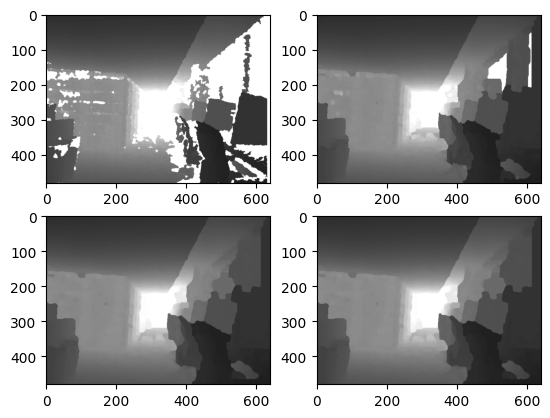

In [58]:
plotting = 1
if plotting == 1:

    # Corridor
    proj_1   = depth_objects[0].projected_depths
    compl_11 = depth_objects[0].completed_depths
    compl_12 = depth_objects[0].completed_depths_2
    filled_1 = depth_objects[0].filled_depths

    # 
    proj_2   = depth_objects_2[1].projected_depths
    compl_21 = depth_objects_2[1].completed_depths
    compl_22 = depth_objects_2[1].completed_depths_2
    filled_2 = depth_objects_2[1].filled_depths

    # Use this
    proj_3   = depth_objects_2[2].projected_depths
    compl_31 = depth_objects_2[2].completed_depths
    compl_32 = depth_objects_2[2].completed_depths_2
    filled_3 = depth_objects_2[2].filled_depths

    # 2_2, 2,4, 2_10, 2_12
    proj_4   = depth_objects_2[12].projected_depths
    compl_41 = depth_objects_2[12].completed_depths
    compl_42 = depth_objects_2[12].completed_depths_2
    filled_4 = depth_objects_2[12].filled_depths

    # 2_2, 2,4, 2_10, 2_12
    proj_5   = depth_objects_2[4].projected_depths
    compl_51 = depth_objects_2[4].completed_depths
    compl_52 = depth_objects_2[4].completed_depths_2
    filled_5 = depth_objects_2[4].filled_depths

    # 2_2, 2,4, 2_10, 2_12
    proj_6   = depth_objects_2[10].projected_depths
    compl_61 = depth_objects_2[10].completed_depths
    compl_62 = depth_objects_2[10].completed_depths_2
    filled_6 = depth_objects_2[10].filled_depths
    
    # Plot the subplots
    # Plot 1
    plt.subplot(2, 2, 1)
    #plt.plot(x, y1, 'g')
    plt.imshow(proj_2, cmap='gray', vmin=0, vmax=MAX_DEPTH)
    plt.axis('off')
    # Plot 2
    plt.subplot(2, 2, 2)
    #plt.plot(x, y2, '-.r')
    plt.imshow(compl_21, cmap='gray', vmin=0, vmax=MAX_DEPTH)
    plt.axis('off')
    # Plot 3
    plt.subplot(2, 2, 3)
    #plt.plot(x, y3, ':y')
    plt.imshow(compl_22, cmap='gray', vmin=0, vmax=MAX_DEPTH)
    plt.axis('off')
    # Plot 4
    plt.subplot(2, 2, 4)
    #plt.plot(x, y4, '--c')
    plt.imshow(filled_2, cmap='gray', vmin=0, vmax=MAX_DEPTH)
    plt.axis('off')
    plt.show()

In [82]:
def process_images_no_filling(depth_image_list):
    # Declare global variables from above snippet
    global MAX_DEPTH
    global DEPTH_PARAM1
    global DEPTH_PARAM2
    global fill_type
    global extrapolate
    global blur_type
    global custom_kernel
    global morph_kernel
    global dilation_kernel
    global pickle_counter

    image_array = []
    image_num = 0
    for depth_path in depth_image_list:
        print(image_num)
        image_num += 1
        
        try:
            # Read depth image
            depth_image = read_pgm(depth_path)
            # Convert to metres
            projected_depths = convert_to_metres(depth_image)
            projected_depths = np.clip(projected_depths, 0, MAX_DEPTH - 0.03)
            projected_depths = (projected_depths).astype(np.float32)

            print(custom_kernel)
            # Fill in
            if fill_type == 'fast':
                completed_depths = fill_in_fast(
                    projected_depths, max_depth=MAX_DEPTH, extrapolate=extrapolate, blur_type=blur_type, 
                    morph_kernel=morph_kernel, dilation_kernel=dilation_kernel)

                completed_depths_2 = fill_in_fast(
                    completed_depths, max_depth=MAX_DEPTH, extrapolate=extrapolate, blur_type=blur_type, 
                    morph_kernel=morph_kernel, dilation_kernel=dilation_kernel)
                
                projected_depths = np.ones([N_ROWS, N_COLS])*MAX_DEPTH - projected_depths
                projected_depths[projected_depths==EMPTY] = MAX_DEPTH

                completed_depths = np.ones([N_ROWS, N_COLS])*MAX_DEPTH - completed_depths
                completed_depths[completed_depths==EMPTY] = MAX_DEPTH

                completed_depths_2[completed_depths_2==EMPTY] = MAX_DEPTH

                #filled_depths = np.ones([N_ROWS, N_COLS])*MAX_DEPTH - filled_depths

                image_array.append(SingleImageProcessSequence2(projected_depths, completed_depths, completed_depths_2))
            else:
                raise ValueError('Invalid fill_type {}'.format(fill_type))
            
        except:
            print("Error processing file: {}".format(depth_path))
            continue
    
    return image_array

class SingleImageProcessSequence2:
    def __init__(self, projected_depths, completed_depths, completed_depths_2):
        self.projected_depths = projected_depths
        self.completed_depths = completed_depths
        self.completed_depths_2 = completed_depths_2

In [60]:
# Best settings so far: 
fill_type = 'fast'
extrapolate = True
blur_type = None

# Fast fill kernels
custom_kernel = DIAMOND_KERNEL_7
morph_kernel = FULL_KERNEL_5
dilation_kernel = FULL_KERNEL_7

depth_image_paths = glob.glob('kernel_settings/*.pgm', recursive=True)
#0, 1, 4?, 7, 9? (railing), 13, 15
depth_image_paths = [depth_image_paths[0], depth_image_paths[1], depth_image_paths[7], depth_image_paths[9], depth_image_paths[13], depth_image_paths[15]]


depth_objects_d7f57e = process_images_no_filling(depth_image_paths)

extrapolate = False
depth_objects_d7f57 = process_images_no_filling(depth_image_paths)

extrapolate = True
blur_type = 'Gaussian'

depth_objects_d7f57eg = process_images_no_filling(depth_image_paths)

custom_kernel = DIAMOND_KERNEL_9
morph_kernel = FULL_KERNEL_7
dilation_kernel = FULL_KERNEL_9
blur_type = None

depth_objects_d9f79e = process_images_no_filling(depth_image_paths)

custom_kernel = DIAMOND_KERNEL_9
morph_kernel = FULL_KERNEL_3
dilation_kernel = FULL_KERNEL_5
depth_objects_d9f35e = process_images_no_filling(depth_image_paths)


custom_kernel = CROSS_KERNEL_7
morph_kernel = FULL_KERNEL_5
dilation_kernel = FULL_KERNEL_7
depth_objects_c7f57e = process_images_no_filling(depth_image_paths)




0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5


0
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1

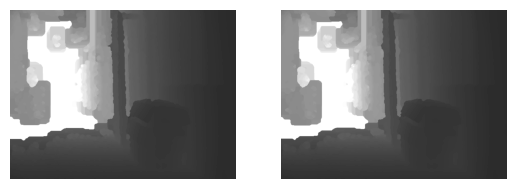

In [83]:
compl_e_1 = depth_objects_d7f57e[0].completed_depths
compl_1 = depth_objects_d7f57[0].completed_depths

custom_kernel = FULL_KERNEL_31
morph_kernel = FULL_KERNEL_7
dilation_kernel = FULL_KERNEL_9
depth_objects_f31f79e = process_images_no_filling(depth_image_paths)

compl_1 = depth_objects_f31f79e[0].completed_depths

plt.subplot(1, 2, 1)
plt.imshow(compl_e_1, cmap='gray', vmin=0, vmax=MAX_DEPTH)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(compl_1, cmap='gray', vmin=0, vmax=MAX_DEPTH)
plt.axis('off')


plt.show()

0
1
2
3
4
5


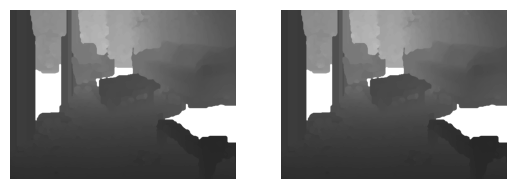

In [77]:
custom_kernel = DIAMOND_KERNEL_5
morph_kernel = FULL_KERNEL_3
dilation_kernel = FULL_KERNEL_5
depth_objects_d5f35e = process_images_no_filling(depth_image_paths)

compl_e_1 = depth_objects_d9f79e[5].completed_depths
compl_1 = depth_objects_d5f35e[5].completed_depths

plt.subplot(1, 2, 1)
plt.imshow(compl_e_1, cmap='gray', vmin=0, vmax=MAX_DEPTH)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(compl_1, cmap='gray', vmin=0, vmax=MAX_DEPTH)
plt.axis('off')
plt.show()

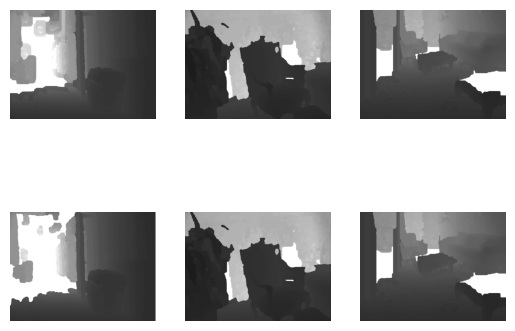

In [68]:

compl_e_1 = depth_objects_d7f57e[0].completed_depths
compl_e_2 = depth_objects_d7f57e[2].completed_depths
compl_e_3 = depth_objects_d7f57e[5].completed_depths

#depth_objects_d7f57
compl_1 = depth_objects_d7f57[0].completed_depths
compl_2 = depth_objects_d7f57[2].completed_depths
compl_3 = depth_objects_d7f57[5].completed_depths

plt.subplot(2, 3, 1)
plt.imshow(compl_e_1, cmap='gray', vmin=0, vmax=MAX_DEPTH)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(compl_e_2, cmap='gray', vmin=0, vmax=MAX_DEPTH)
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(compl_e_3, cmap='gray', vmin=0, vmax=MAX_DEPTH)
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(compl_1, cmap='gray', vmin=0, vmax=MAX_DEPTH)
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(compl_2, cmap='gray', vmin=0, vmax=MAX_DEPTH)
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(compl_3, cmap='gray', vmin=0, vmax=MAX_DEPTH)
plt.axis('off')
plt.show()

In [ ]:


depth_objects_d7f57eg


depth_objects_d9f79e
depth_objects_d9f35e 
depth_objects_c7f57e 

In [54]:
# Best settings so far: 
fill_type = 'fast'
extrapolate = False
blur_type = None

# Fast fill kernels
custom_kernel = DIAMOND_KERNEL_7
morph_kernel = FULL_KERNEL_5
dilation_kernel = FULL_KERNEL_7
depth_image_paths = glob.glob('kernel_settings/*.pgm', recursive=True)
#0, 1, 4?, 7, 9? (railing), 13, 15
depth_image_paths = [depth_image_paths[0], depth_image_paths[1], depth_image_paths[7], depth_image_paths[9], depth_image_paths[13], depth_image_paths[15]]
depth_objects_d7f57 = process_images_no_filling(depth_image_paths)

0
1
2
3
4
5


<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\ingvilcf\AppData\Local\Temp\ipykernel_14448\1935992529.py:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if plotting is 1:


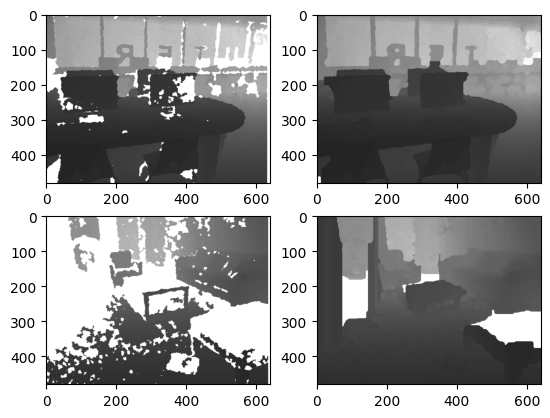

In [59]:
plotting = 1
if plotting is 1:

    # Corridor
    ne_proj_1   = depth_objects_n1[0].projected_depths
    ne_compl_11 = depth_objects_n1[0].completed_depths
    ne_compl_12 = depth_objects_n1[0].completed_depths_2

    # Window, floor
    ne_proj_2   = depth_objects_n1[1].projected_depths
    ne_compl_21 = depth_objects_n1[1].completed_depths
    ne_compl_22 = depth_objects_n1[1].completed_depths_2
    # Chair, railing plant
    ne_proj_3   = depth_objects_n1[2].projected_depths
    ne_compl_31 = depth_objects_n1[2].completed_depths
    ne_compl_32 = depth_objects_n1[2].completed_depths_2
    # Railing, chair, plant
    ne_proj_4   = depth_objects_n1[3].projected_depths
    ne_compl_41 = depth_objects_n1[3].completed_depths
    ne_compl_42 = depth_objects_n1[3].completed_depths_2
    # PC lab
    ne_proj_5   = depth_objects_n1[4].projected_depths
    ne_compl_51 = depth_objects_n1[4].completed_depths
    ne_compl_52 = depth_objects_n1[4].completed_depths_2
    # Living room
    ne_proj_6   = depth_objects_n1[5].projected_depths
    ne_compl_61 = depth_objects_n1[5].completed_depths
    ne_compl_62 = depth_objects_n1[5].completed_depths_2
    
    # Plot the subplots
    # Plot 1
    plt.subplot(2, 2, 1)
    #plt.plot(x, y1, 'g')
    plt.imshow(ne_proj_5, cmap='gray', vmin=0, vmax=MAX_DEPTH)
    # Plot 2
    plt.subplot(2, 2, 2)
    #plt.plot(x, y2, '-.r')
    plt.imshow(ne_compl_51, cmap='gray', vmin=0, vmax=MAX_DEPTH)
    # Plot 3
    plt.subplot(2, 2, 3)
    #plt.plot(x, y3, ':y')
    plt.imshow(ne_proj_6, cmap='gray', vmin=0, vmax=MAX_DEPTH)
    # Plot 4
    plt.subplot(2, 2, 4)
    #plt.plot(x, y4, '--c')
    plt.imshow(ne_compl_61, cmap='gray', vmin=0, vmax=MAX_DEPTH)
    plt.show()